In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

In [2]:
result_path = Path(os.getcwd()) / "results"

In [3]:
result_summary = {}
summary_file_name = "summary.json"
output_path = Path(os.getcwd()).parent / "analysis_results"

In [4]:
df = pd.read_csv(output_path / "summary.csv")
df = df[~df['model'].str.startswith('llama')]

In [5]:
df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,model,task,pe_technique,correct,total,accuracy,created_at,...,median_length,std_length,min_length,max_length,mean_time_taken,median_time_taken,std_time_taken,min_time_taken,max_time_taken,total_time_taken
0,pythia-160m,math-number,zero-shot,pythia-160m,math-number,zero-shot,0,540,0.000000,2024-05-04-08-53-45,...,10000,2502.600344,4331,17701,19.871409,19.951003,0.506602,14.162299,20.882381,10730.560791
1,pythia-160m,math-number,null-shot,pythia-160m,math-number,null-shot,0,540,0.000000,2024-05-04-11-52-37,...,11183,2716.999606,5558,16882,19.775824,19.806719,0.174244,18.703898,20.600824,10678.945112
2,pythia-160m,math-algebra,zero-shot,pythia-160m,math-algebra,zero-shot,0,1187,0.000000,2024-05-03-09-25-22,...,9558,2816.592556,3172,27789,19.980845,19.958036,1.788766,14.680008,77.402771,23717.263572
3,pythia-160m,math-algebra,null-shot,pythia-160m,math-algebra,null-shot,0,1187,0.000000,2024-05-03-16-00-41,...,9825,2907.029382,4342,23504,19.751473,19.790684,0.319809,15.446048,20.999895,23444.998943
4,pythia-160m,anli,zero-shot,pythia-160m,anli,zero-shot,90,1200,7.500000,2024-03-02-10-13-32,...,13640,2102.988893,212,21359,32.997478,33.507348,2.462416,0.398390,34.808553,39596.973934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,claude-3-sonnet,math-count-prob,null-shot,claude-3-sonnet,math-count-prob,null-shot,156,474,32.911392,2024-05-02-02-07-41,...,963,358.438092,300,3126,5.864559,5.607845,1.787604,2.737045,17.119768,2779.800778
1098,claude-3-sonnet,math-pre-calc,zero-shot,claude-3-sonnet,math-pre-calc,zero-shot,107,546,19.597070,2024-05-03-01-41-50,...,967,388.633445,21,2817,7.165183,7.106678,2.826064,1.009600,23.492027,3912.190082
1099,claude-3-sonnet,math-pre-calc,null-shot-cot,claude-3-sonnet,math-pre-calc,null-shot-cot,50,546,9.157509,2024-05-03-05-08-02,...,1373,622.037013,360,11765,10.132054,9.799197,3.386665,2.954349,49.937672,5532.101600
1100,claude-3-sonnet,math-pre-calc,zero-shot-cot,claude-3-sonnet,math-pre-calc,zero-shot-cot,98,546,17.948718,2024-05-03-03-55-03,...,1078,410.344098,304,2673,7.977967,7.586558,2.894636,2.467906,19.092086,4355.970111


In [6]:
def model_name_to_size(model_name: str) -> float:
    model_name_pattern = r'.*-(\d*(.\d*)?[mb])(-chat)?'
    acronyms = {'m': 1e6, 'b': 1e9}
    match = re.match(model_name_pattern, model_name)
    if match:
        size = match.group(1)
        if size[-1] in acronyms:
            return float(size[:-1]) * acronyms[size[-1]]
        else:
            return float(size)
    else:
        return 0

In [7]:
model_name_to_size("qwen-1.5-31b")

31000000000.0

In [8]:
sns.set_style('white')
sns.set_context("paper", font_scale=2)

In [62]:
def visualize_by_model(filtered_df: pd.DataFrame, model_name: str):
    filtered_df = filtered_df[filtered_df['model'].str.startswith(model_name)]
    # Group by 'task' and calculate the total for each task
    task_totals = filtered_df.groupby('task')['total'].sum()

    filtered_df = filtered_df.assign(model_size=filtered_df['model'].apply(model_name_to_size))

    # Create the plot using seaborn
    g = sns.relplot(
        data=filtered_df, x='model_size', y='accuracy', hue='pe_technique',
        kind='line', style='pe_technique', col='task',
        markers=True, dashes=False, palette='colorblind', markersize=10, aspect=1.5,
        facet_kws=dict(sharey=False), col_wrap=3
    )

    # Set x-axis title
    g.set_axis_labels("Model Size", "Accuracy (%)")

    unique_x_ticks = filtered_df['model_size'].unique()
    x_tick_labels = [f"{int(x / 1e6)}M" if x < 1e9 else f"{round(x / 1e9, 1)}B" if x % 1e9 != 0 else f"{int(x / 1e9)}B" for x in unique_x_ticks]

    for ax, task in zip(g.axes.flat, task_totals.index):
        ax.set_ylim(0, 100)  # Set y-axis limits
        ax.set_title(f'Task: {task}')  # Set subplot title
        ax.set_xticks(unique_x_ticks)  # Set x-ticks to the unique values
        ax.set_xticklabels(x_tick_labels, rotation=90, ha='right', fontsize=10)  # Rotate and right-align labels

    plt.suptitle(f"Model: {model_name.title()}")
    plt.subplots_adjust(top=0.88)

    # Modify legend
    g._legend.set_title("PE")

    # Use gray color for the x and y axes
    for ax in g.axes.flat:
        ax.spines['bottom'].set_color('gray')
        ax.spines['left'].set_color('gray')

    # Show the plot
    plt.show()

In [63]:
non_math_df = df[~df['task'].str.startswith('math')]

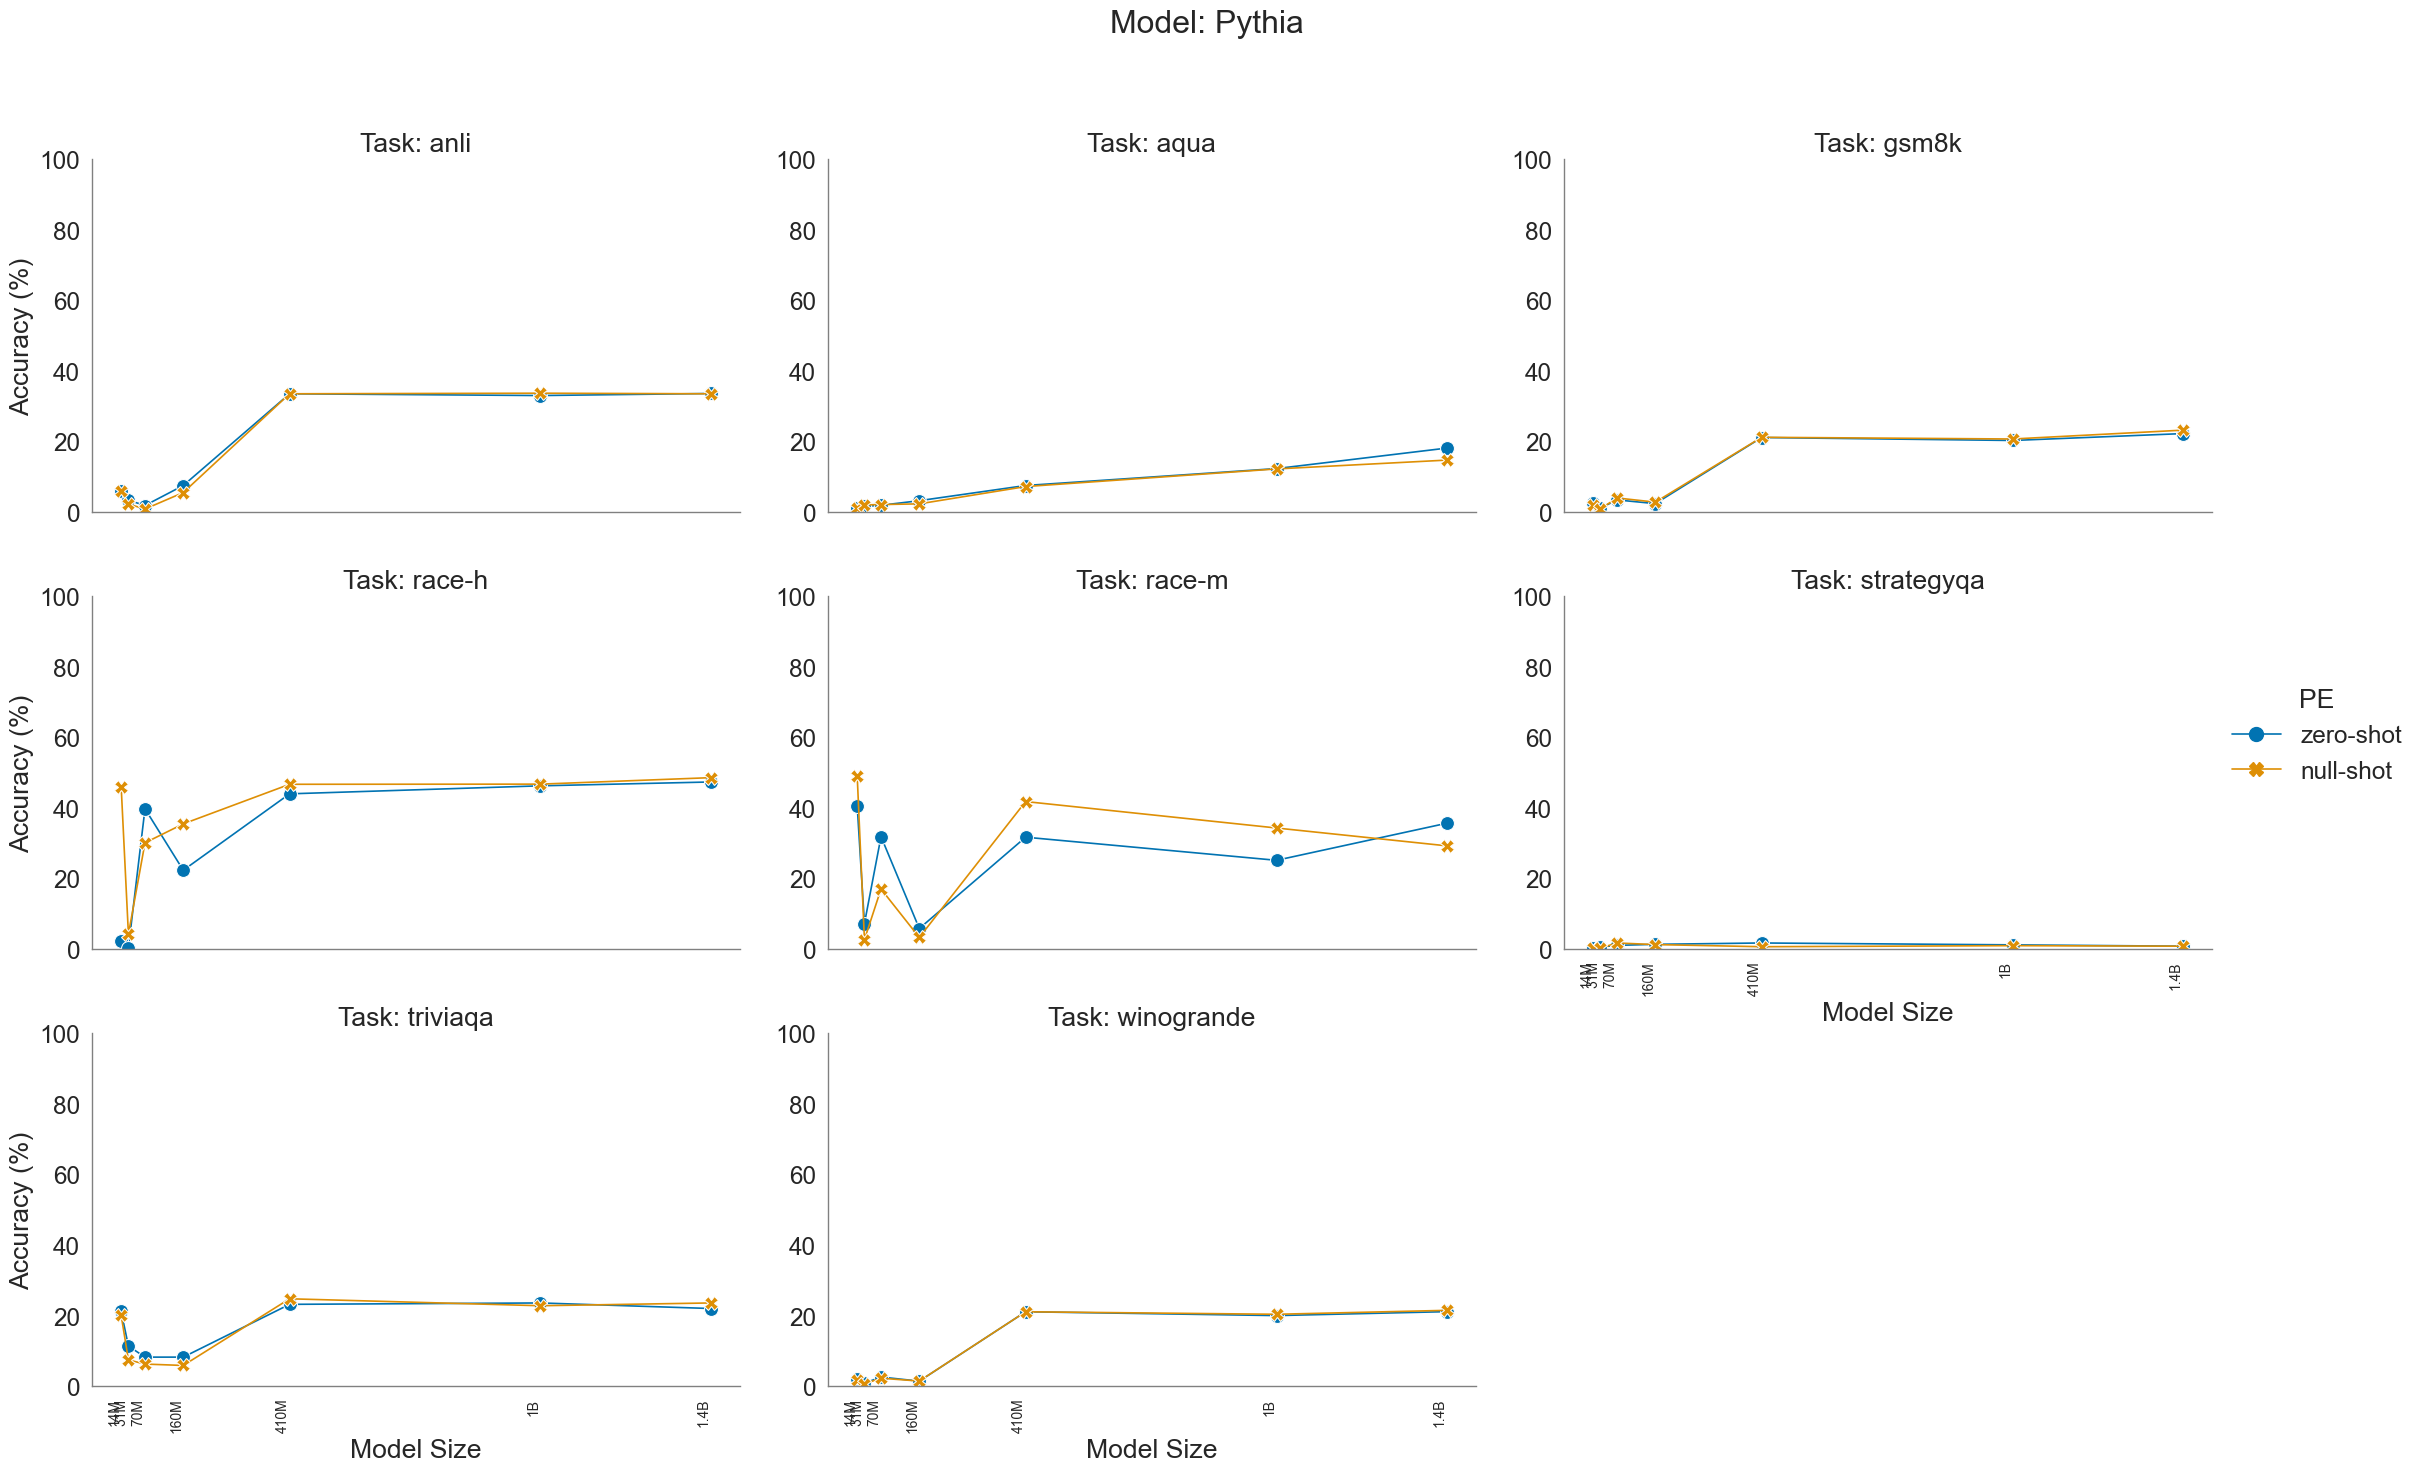

In [64]:
visualize_by_model(non_math_df, "pythia")

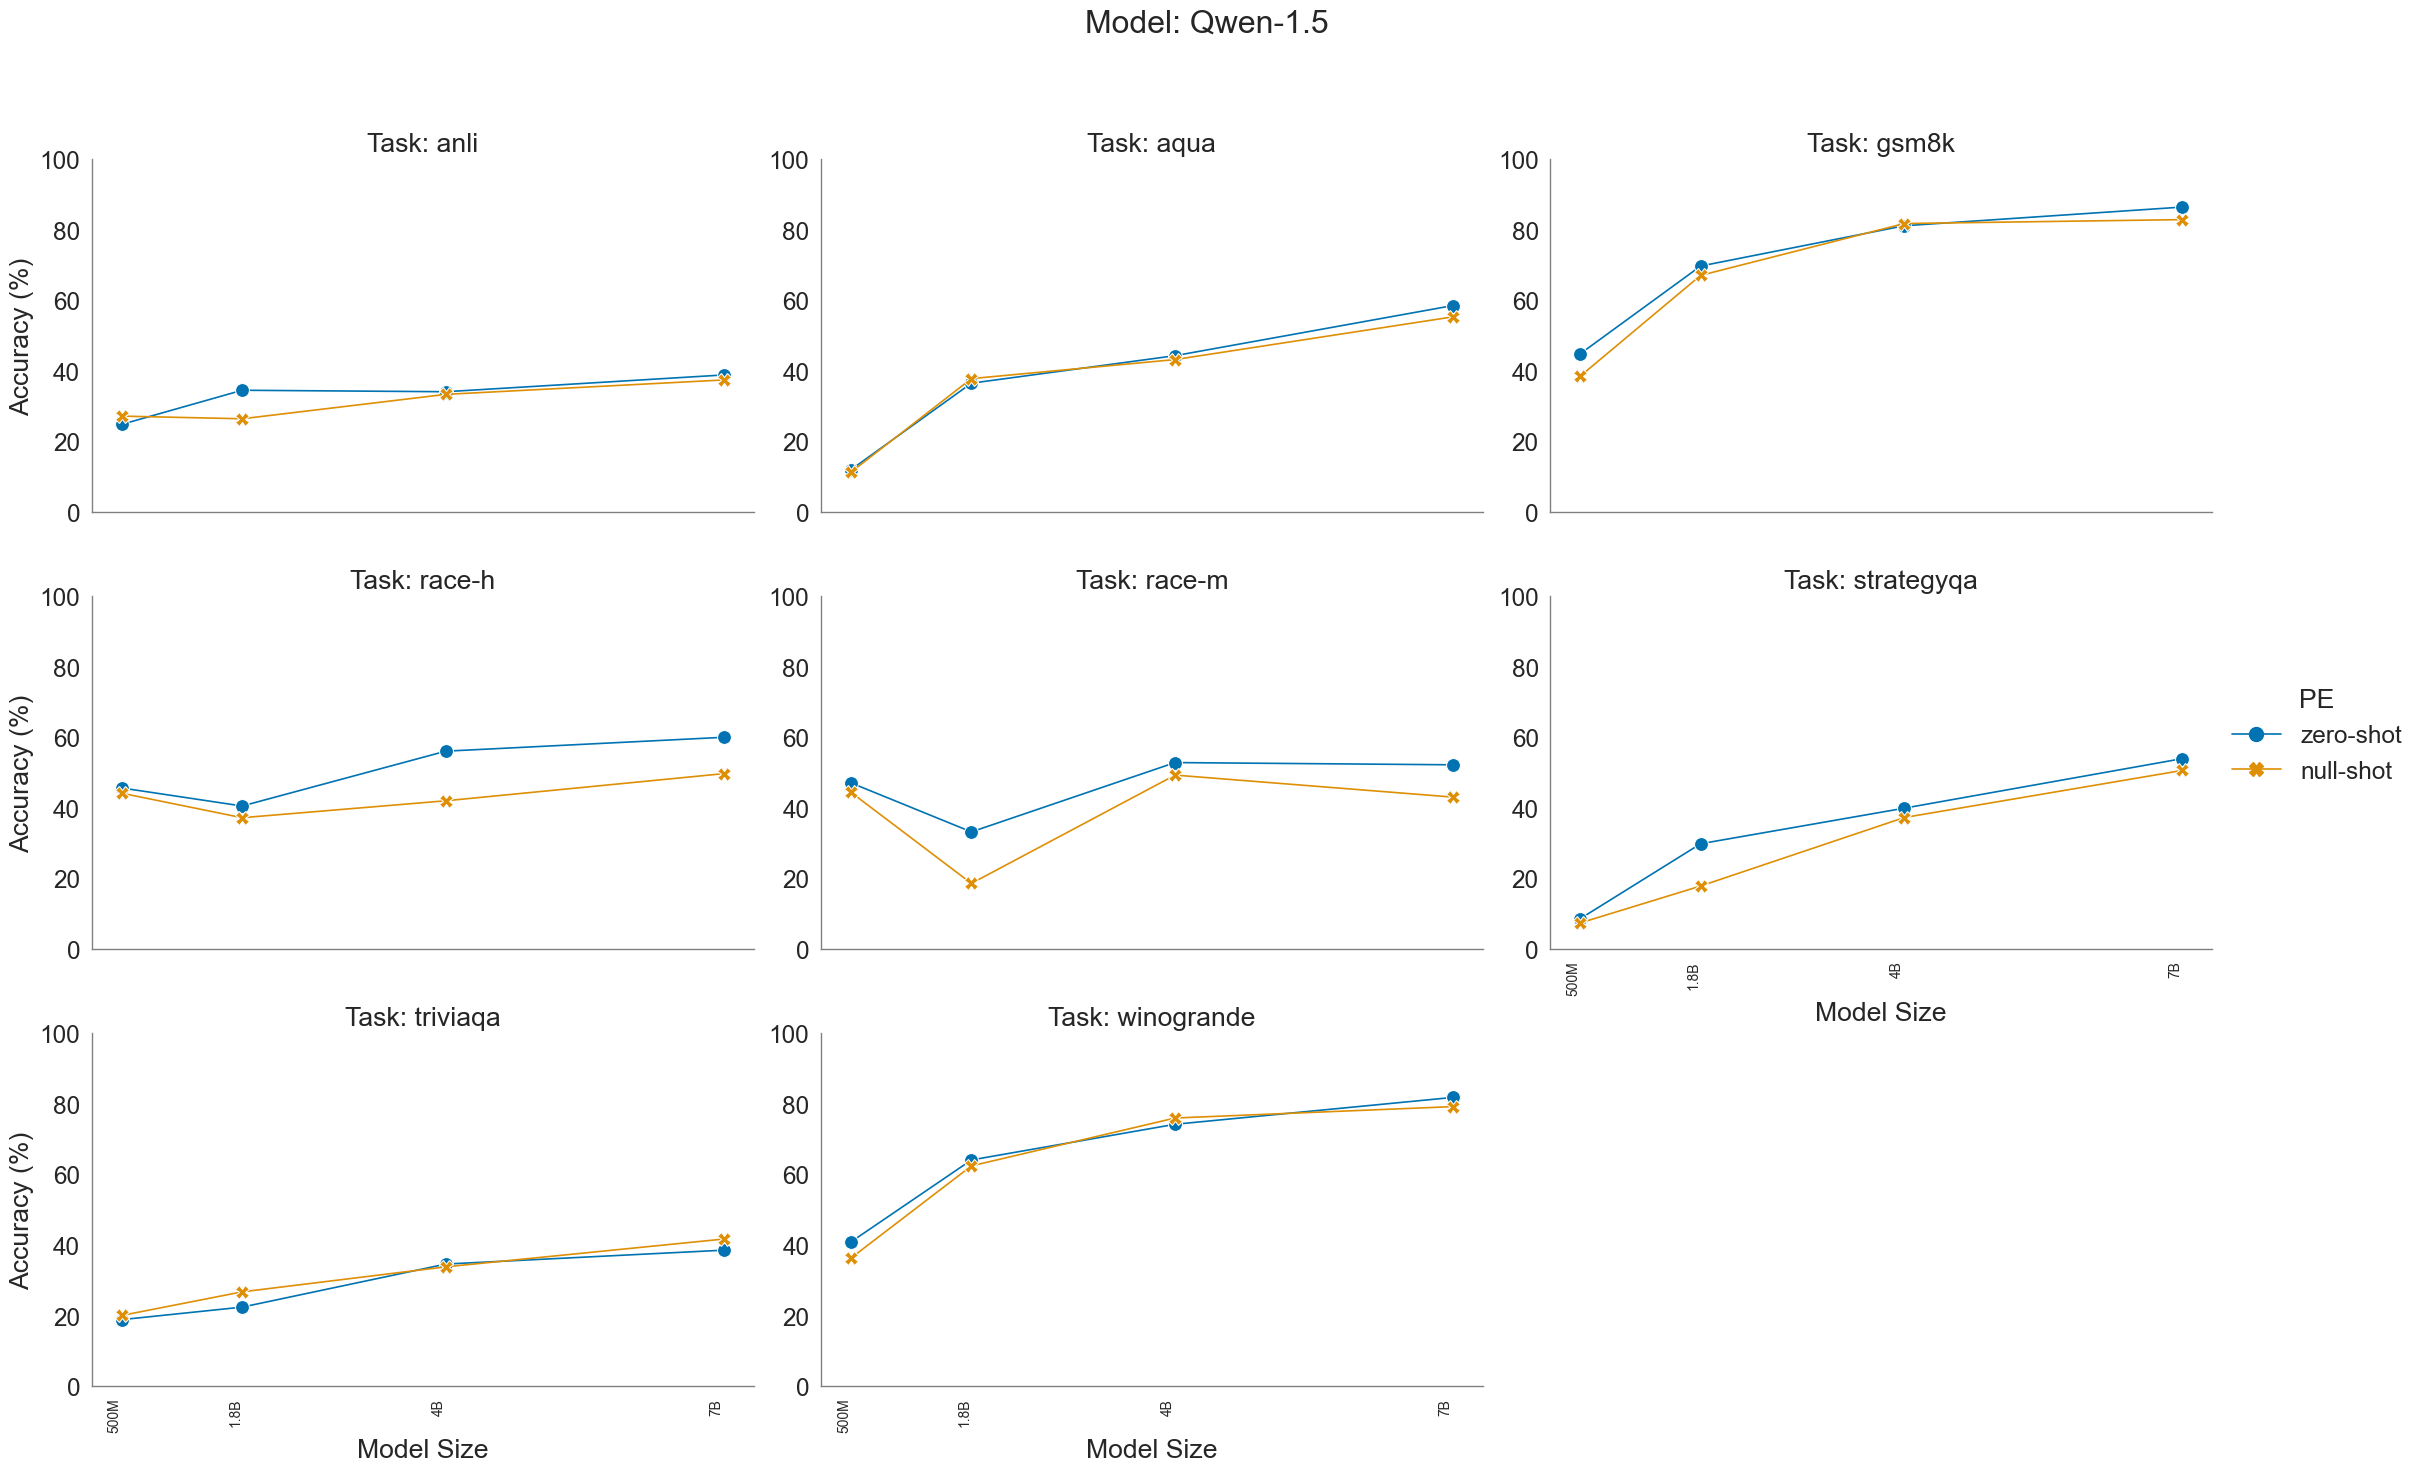

In [65]:
visualize_by_model(non_math_df, "qwen-1.5")

In [66]:
math_df = df[df['task'].str.startswith('math')]

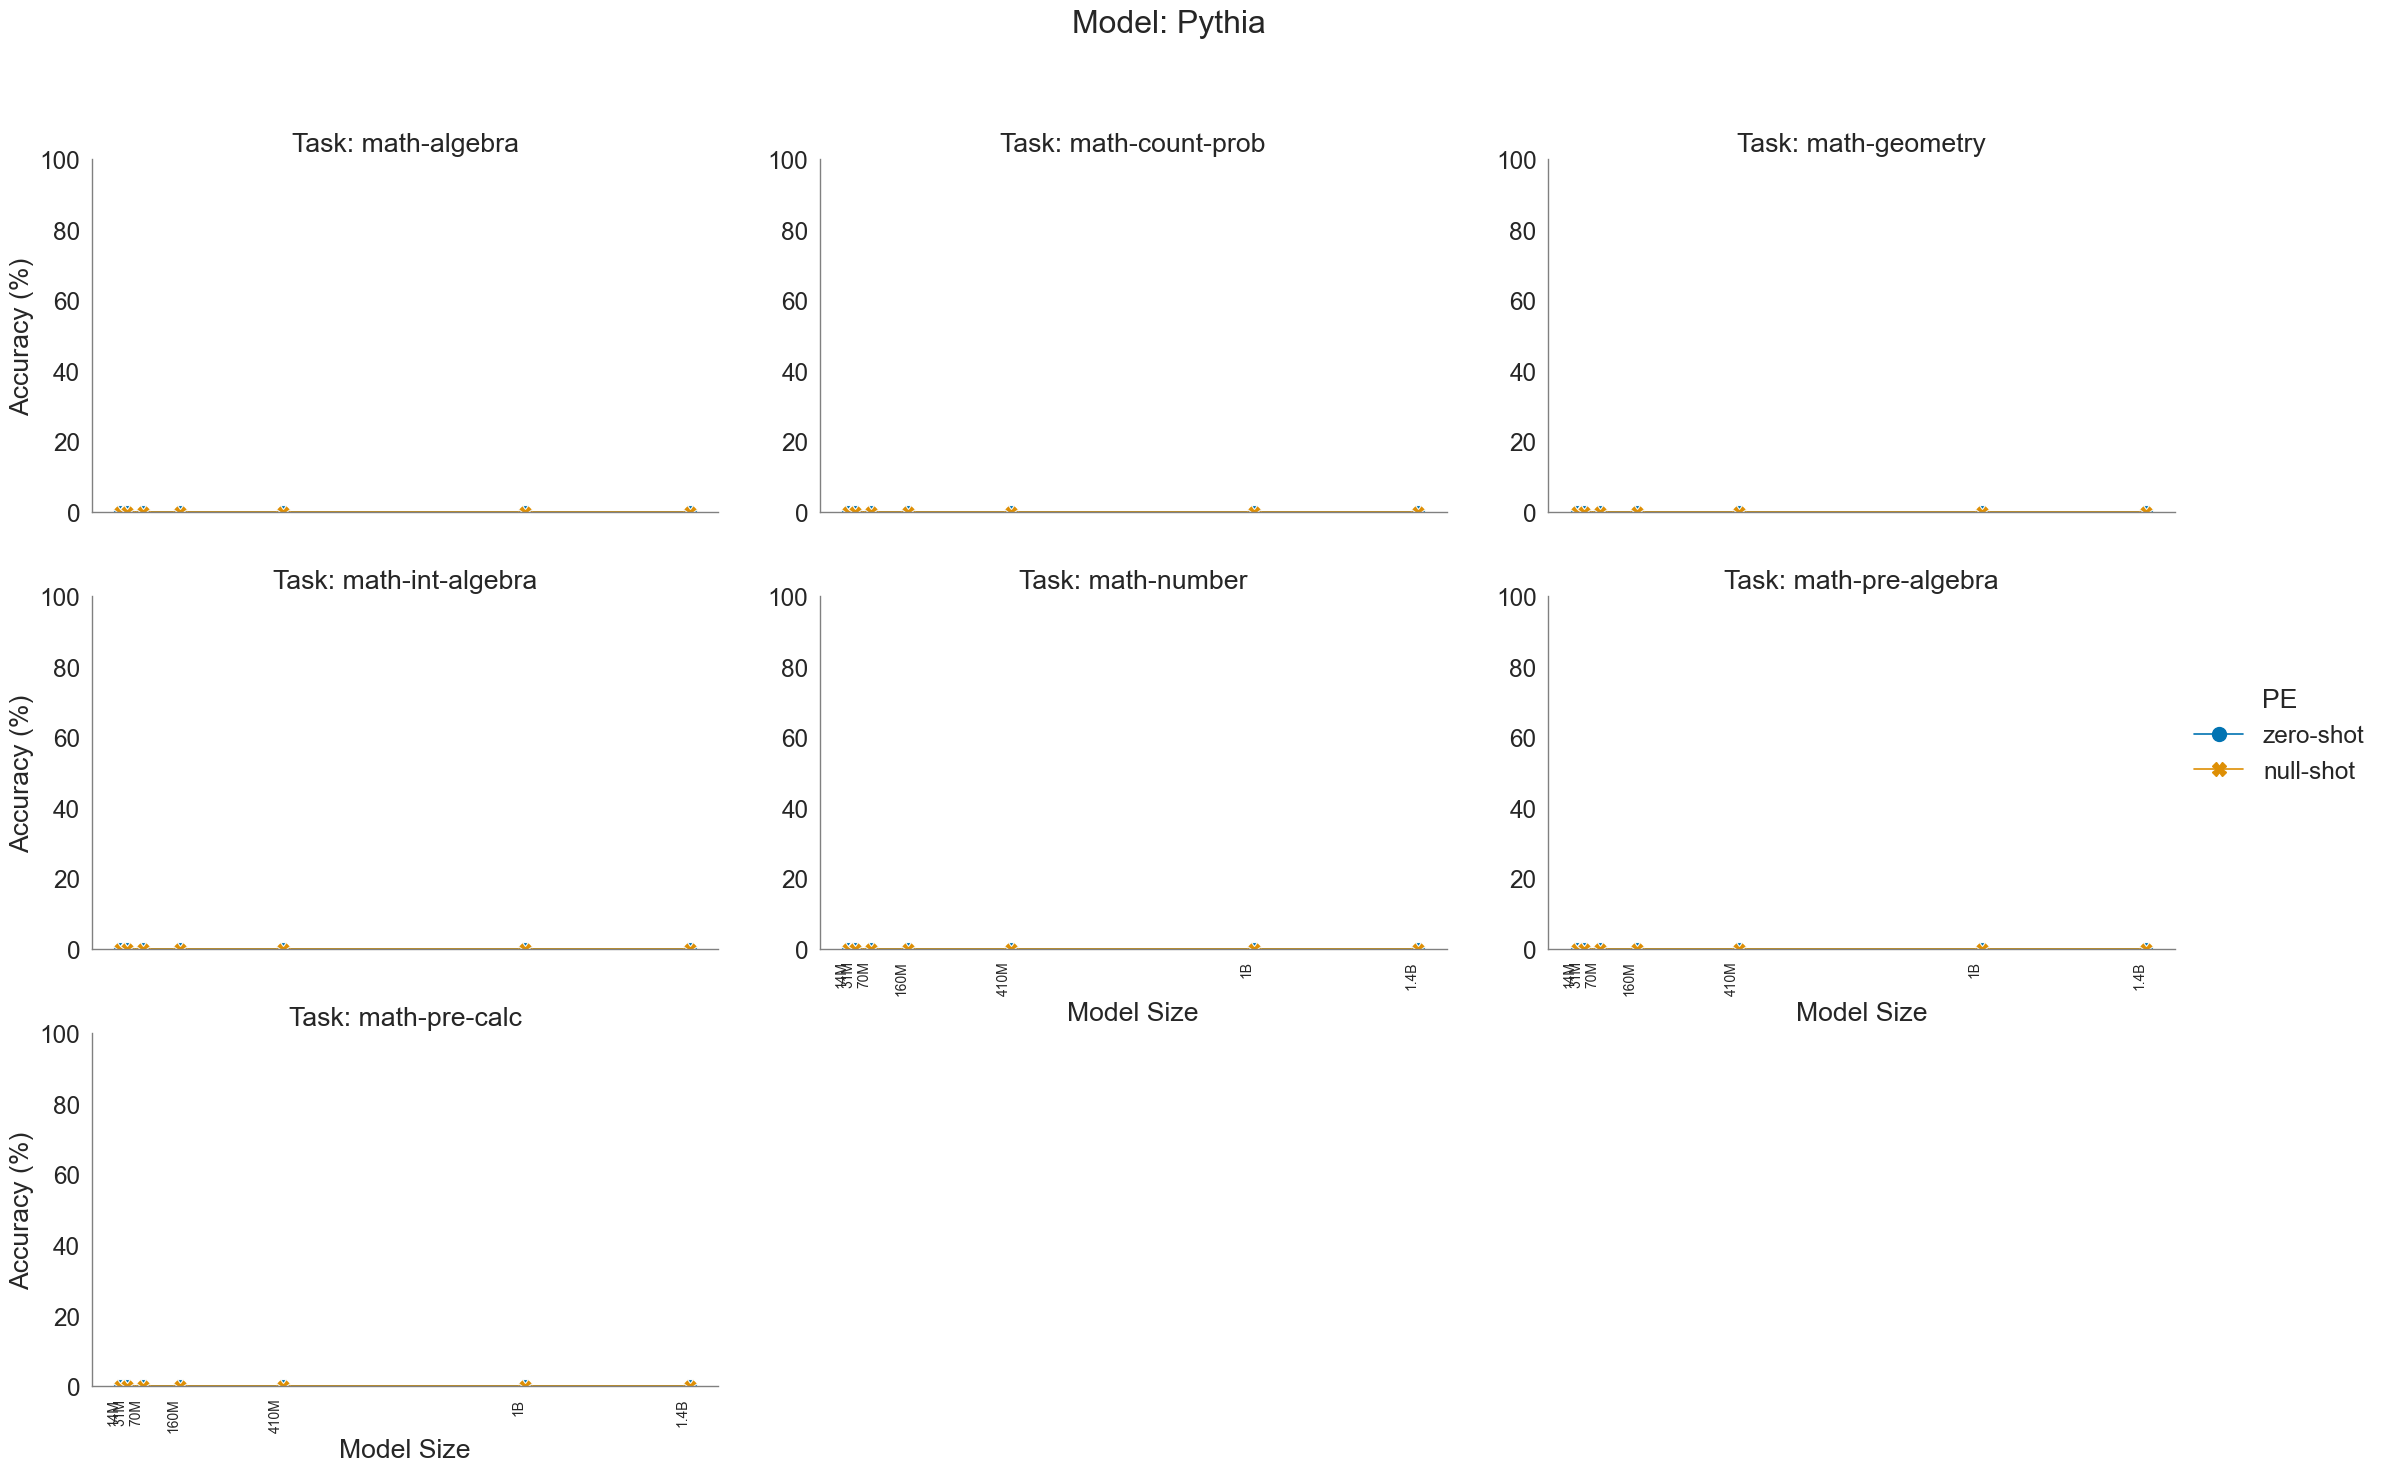

In [67]:
visualize_by_model(math_df, "pythia")

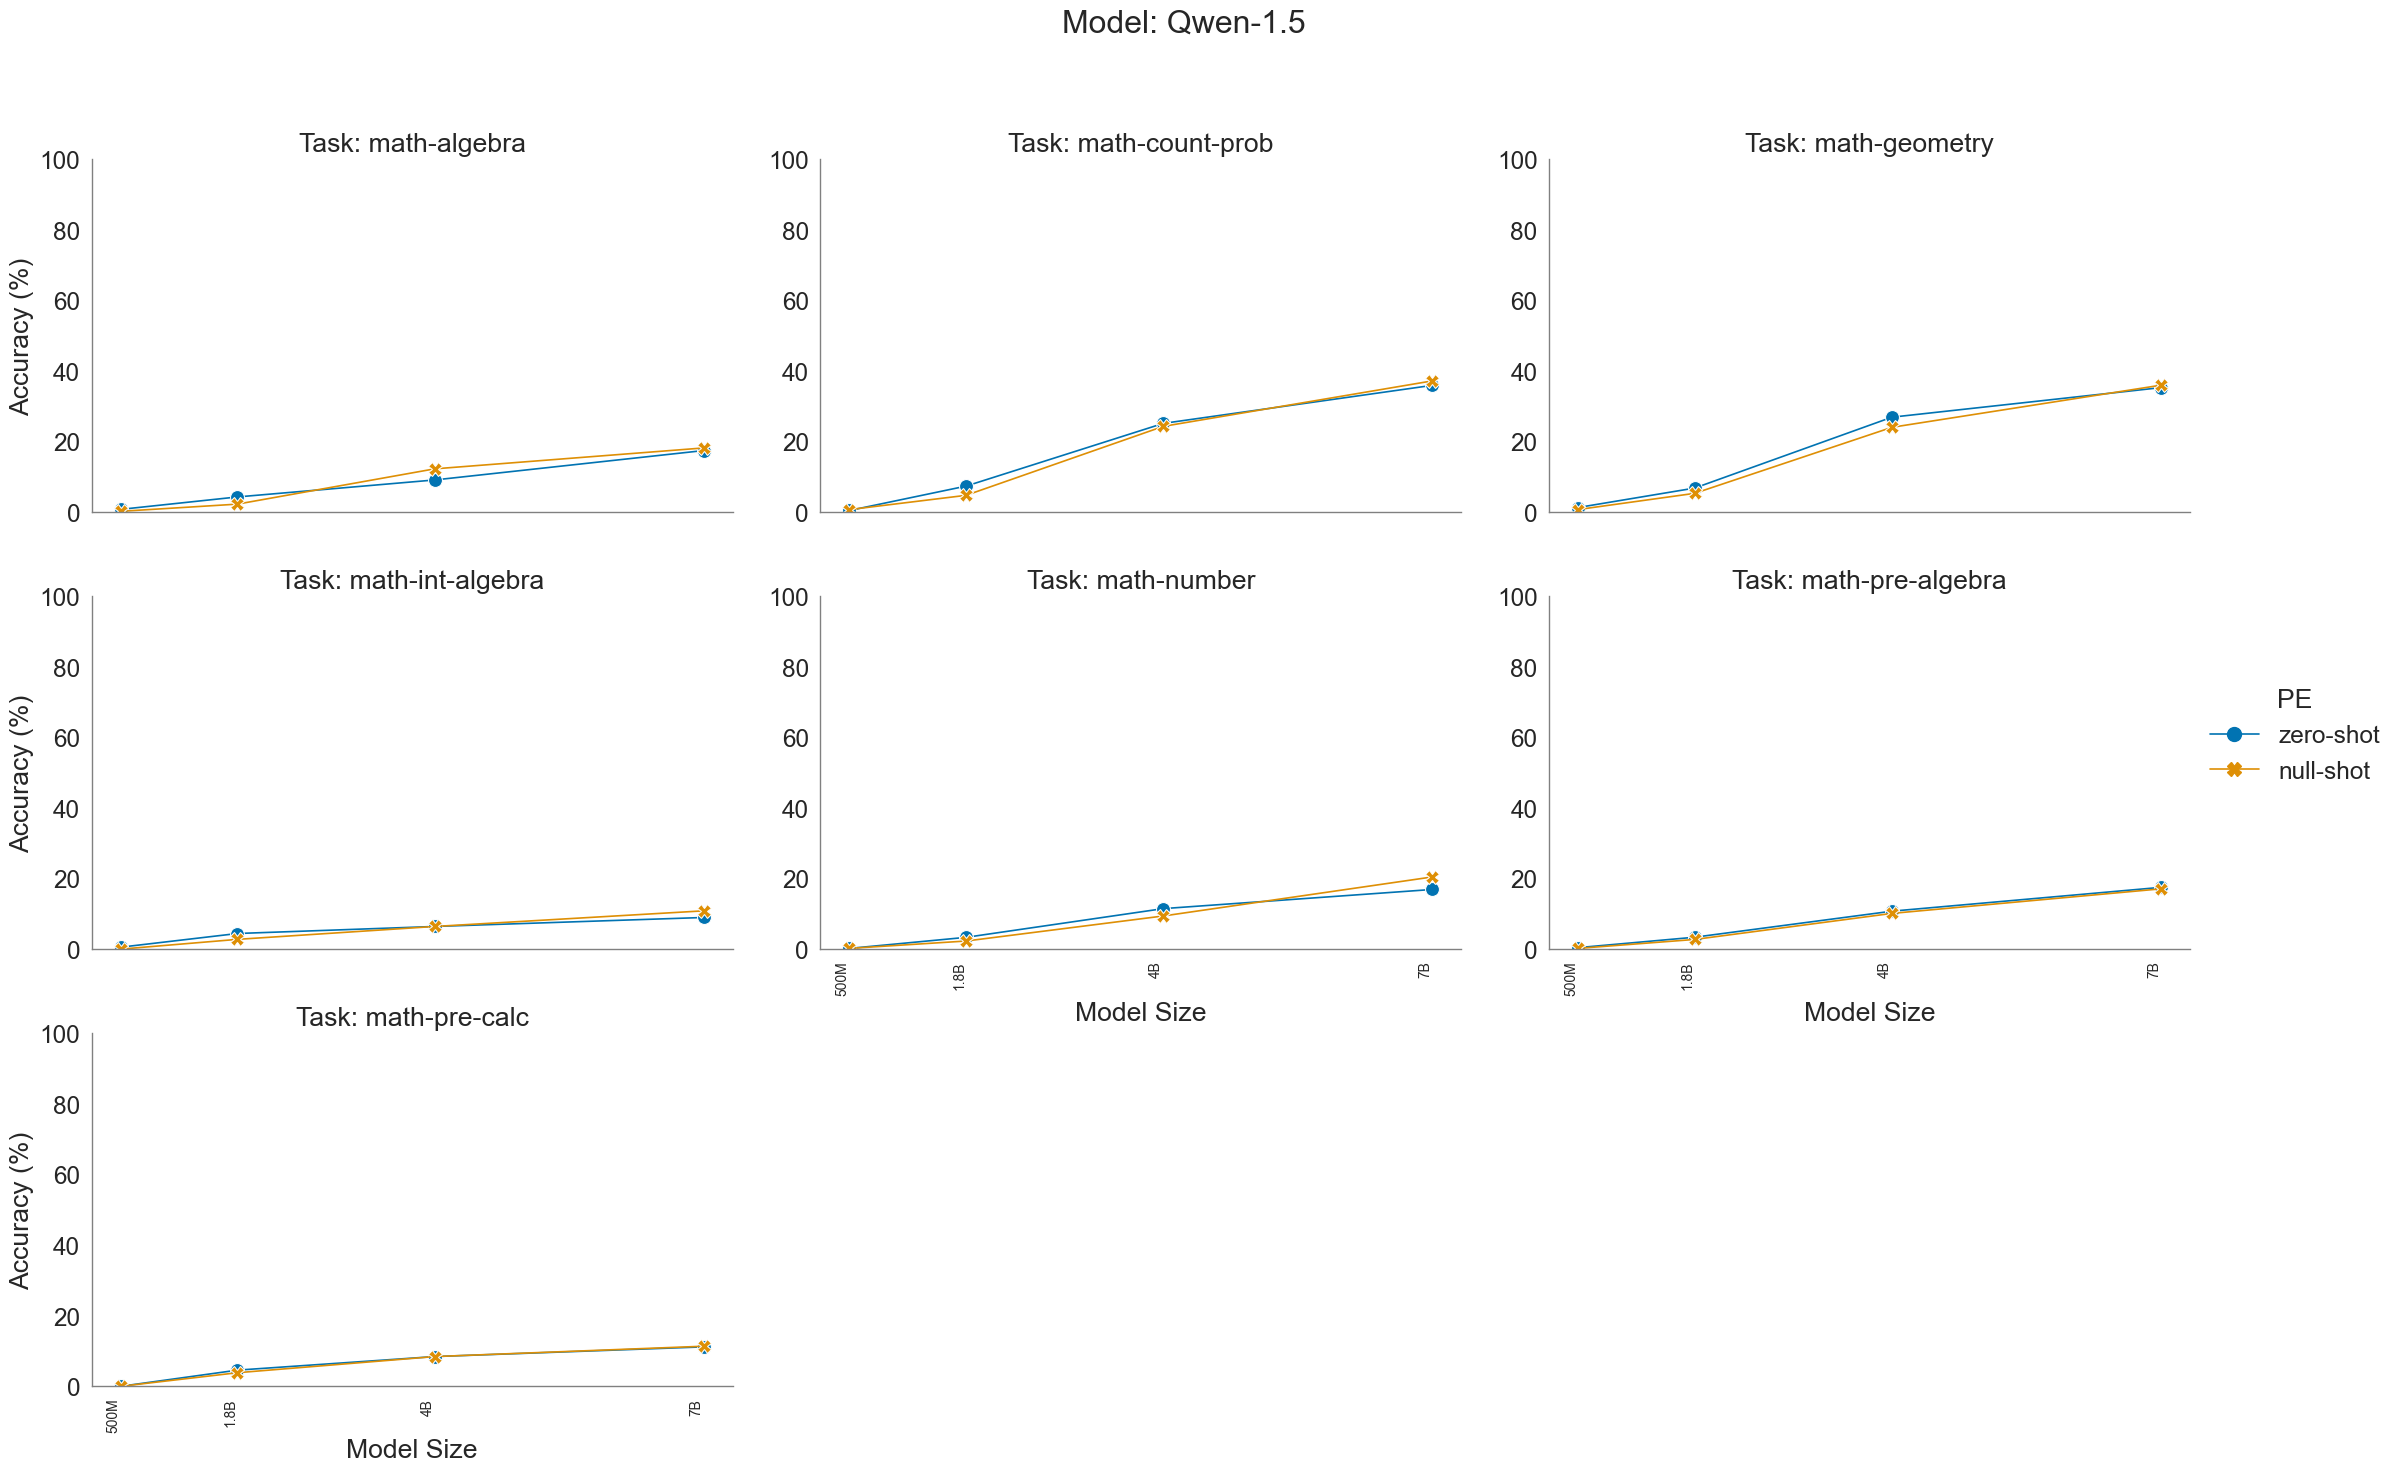

In [68]:
visualize_by_model(math_df, "qwen-1.5")